<a href="https://colab.research.google.com/github/Harriet101-alt/Carbon-BiomassML/blob/main/Cirsco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature Stacking Ensemble
1. Feature Extractors (Level 0)


*   EfficientNet - outputs 1536d vector
*   Swin Transformer - outputs

2. Concatenation (Feature Matrix)

**[CNN Features] + [Transformer Features] + [One-Hot Species] + [NDVI/Height]**

3. Meta-Learner
XGBOOST




Images determined by both fine texture and global structure.
Issue of ground visibility - add a squeeze and excitation block to fusion attention to avoid dark soil pixels.

Max pooling and average pooling. Max pool

Data Investigation

In [ ]:
!curl -fsSL https://deb.nodesource.com/setup_20.x | bash -
!apt-get install -y nodejs

2026-01-31 17:18:27 - Installing pre-requisites
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,328 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:13 

In [ ]:
#Imports
#label encoding for species, standard scaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
#stratified K-fol
from sklearn.model_selection import StratifiedGroupKFold

#for ml
from torch.utils.data import Dataset, DataLoader
import cv2
import torch

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#for file management
import os

#for model imports
from huggingface_hub import hf_hub_download
from torchvision import models

#Use Albumentions for images and targets
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#for model building
from transformers import SwinModel, SwinConfig

In [ ]:
os.environ["KAGGLE_USERNAME"] = "harrietfletcher"
os.environ["KAGGLE_KEY"] = "KGAT_9b2e35059dce5700e1c91411bb4a112d"

# Note: Some versions of the CLI prefer KAGGLE_API_TOKEN
# If the above fails, try adding this as well:
os.environ["KAGGLE_API_TOKEN"] = "KGAT_9b2e35059dce5700e1c91411bb4a112d"

In [ ]:
!kaggle competitions download -c csiro-biomass

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 3, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 33, in <module>
    import requests
  File "/usr/local/lib/python3.12/dist-packages/requests/__init__.py", line 45, in <module>
    from .exceptions import RequestsDependencyWarning
  File "/usr/local/lib/python3.12/dist-packages/requests/exceptions.py", line 127, in <module>
    class StreamConsumedError(RequestException, TypeError):
KeyboardInterrupt
^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save here instead of locally
save_path = f"/content/drive/MyDrive/CSIRO_Project/backbone_fold{fold}.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import Javascript

def keep_alive():
    display(Javascript('''
        function ClickConnect(){
            console.log("Python-injected Keep-Alive active");
            document.querySelector("colab-connect-button").click()
        }
        setInterval(ClickConnect, 60000)
    '''))

keep_alive()

<IPython.core.display.Javascript object>

In [ ]:
import zipfile
# Create folder in Drive
!mkdir -p "/content/drive/MyDrive/csiro_biomass_data"

# Unzip file directly into that folder
!unzip -q /content/csiro-biomass.zip -d "/content/drive/MyDrive/csiro_biomass_data/"

unzip:  cannot find or open /content/csiro-biomass.zip, /content/csiro-biomass.zip.zip or /content/csiro-biomass.zip.ZIP.


In [ ]:
import matplotlib as plt
import pandas as pd

train_data = "/content/drive/MyDrive/csiro_biomass_data/train.csv"
test_data = "/content/drive/MyDrive/csiro_biomass_data/test.csv"

df = pd.read_csv(train_data)
print(df.head())

                    sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  


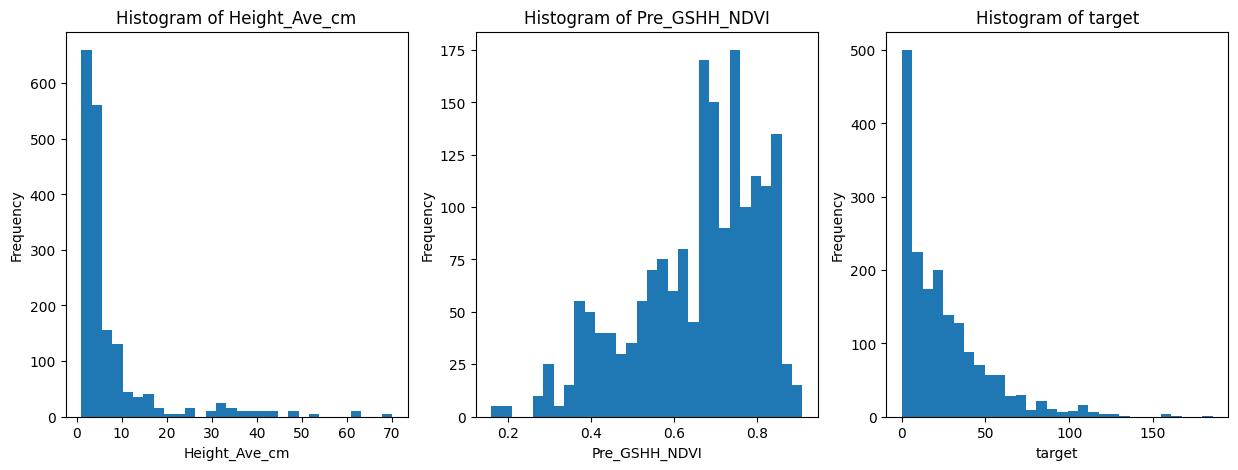

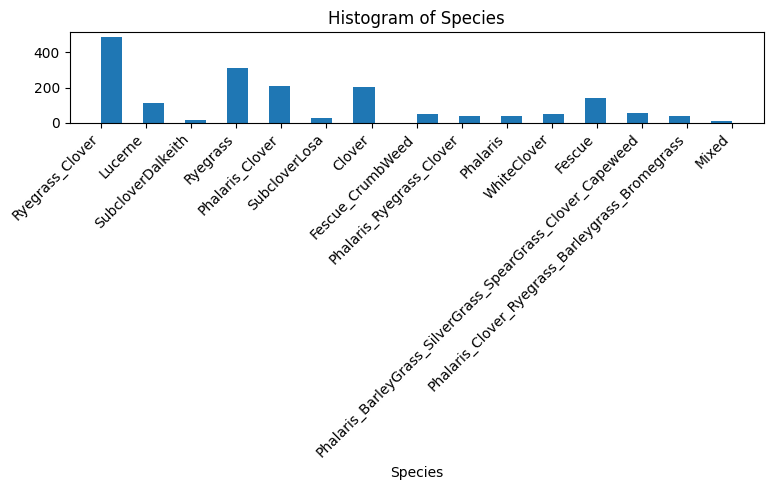

In [ ]:
import matplotlib.pyplot as plt

#inspect data
# Plot histogram for 'Height_Ave_cm'
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df['Height_Ave_cm'].dropna(), bins=30)
plt.title('Histogram of Height_Ave_cm')
plt.xlabel('Height_Ave_cm')
plt.ylabel('Frequency')

# Plot histogram for 'Pre_GSHH_NDVI'
plt.subplot(1, 3, 2)
plt.hist(df['Pre_GSHH_NDVI'].dropna(), bins=30)
plt.title('Histogram of Pre_GSHH_NDVI')
plt.xlabel('Pre_GSHH_NDVI')
plt.ylabel('Frequency')

# Plot histogram for 'target'
plt.subplot(1, 3, 3)
plt.hist(df['target'].dropna(), bins=30)
plt.title('Histogram of target')
plt.xlabel('target')
plt.ylabel('Frequency')

#plot species histogram
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Species'].dropna(), bins=30)
plt.title('Histogram of Species')
plt.xticks(rotation=45, ha ='right')
plt.xlabel('Species')

plt.tight_layout()
plt.show()

In [ ]:
print(df.describe())
# See how many samples exist per State or Species
print(df['State'].value_counts())
print(df['Species'].value_counts())

       Pre_GSHH_NDVI  Height_Ave_cm       target
count    1785.000000    1785.000000  1785.000000
mean        0.657423       7.595985    24.782295
std         0.151972      10.273725    25.823738
min         0.160000       1.000000     0.000000
25%         0.560000       3.000000     4.818200
50%         0.690000       4.000000    18.200000
75%         0.770000       7.000000    35.940600
max         0.910000      70.000000   185.700000
State
Tas    690
Vic    560
NSW    375
WA     160
Name: count, dtype: int64
Species
Ryegrass_Clover                                                490
Ryegrass                                                       310
Phalaris_Clover                                                210
Clover                                                         205
Fescue                                                         140
Lucerne                                                        110
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed     55
Fescue

In [ ]:
print(df['Species'].nunique())

15


Data shortage - mixed, subcloverLosa and Keith

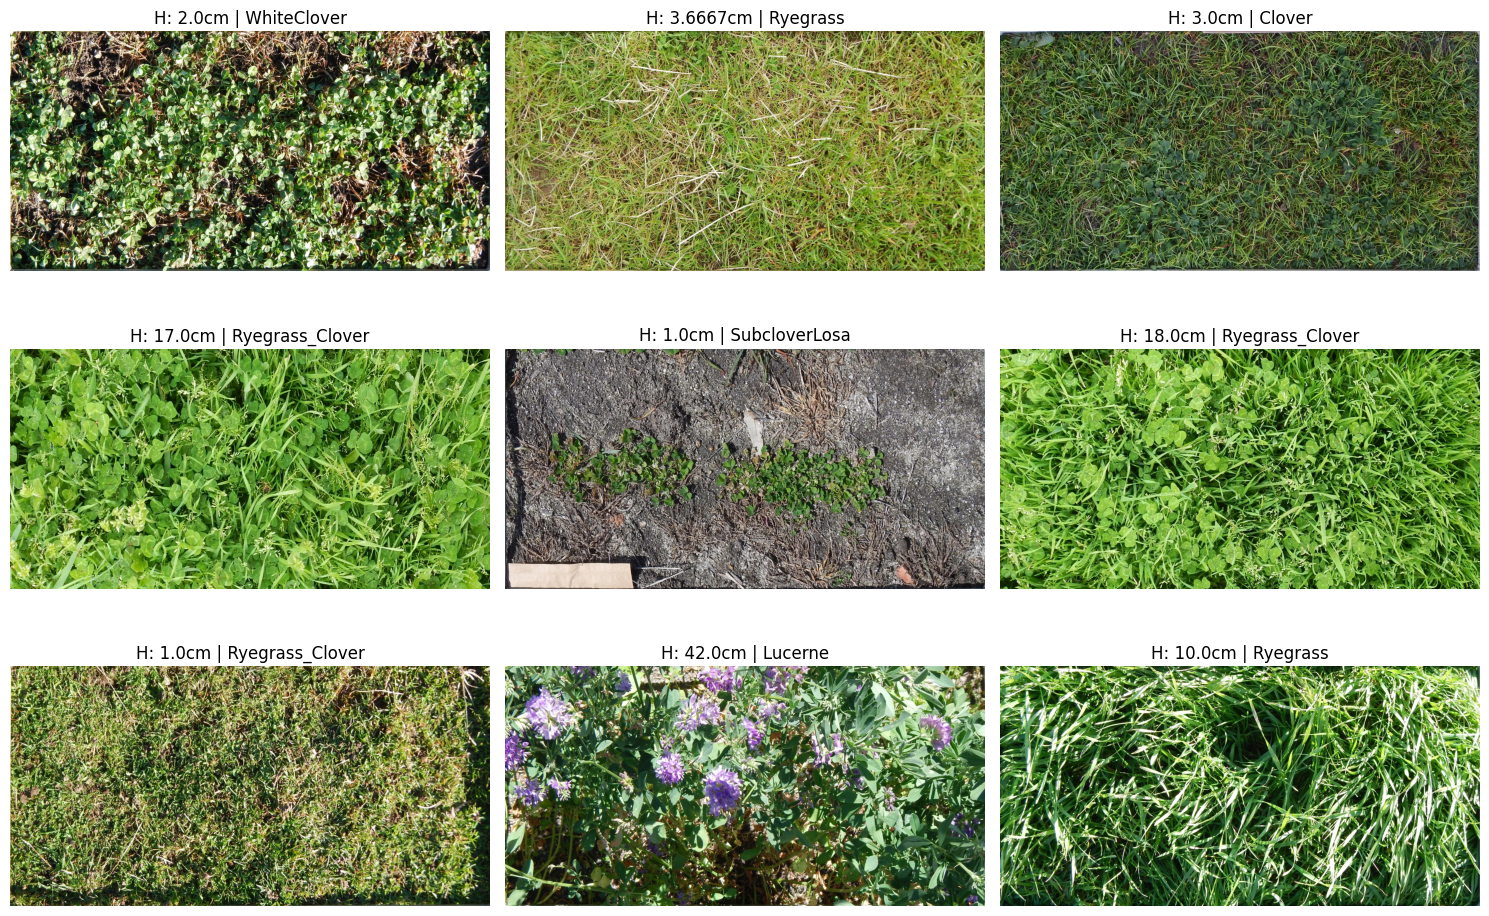

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

def inspect_grid(df, n_rows=3, n_cols=3):
    # Select unique images (since the CSV has 5 rows per image)
    unique_images = df.drop_duplicates(subset=['image_path']).sample(n_rows * n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    for i, (idx, row) in enumerate(unique_images.iterrows()):
        ax = axes[i // n_cols, i % n_cols]
        # Adjust path to your unzipped folder
        img_path = os.path.join("/content/drive/MyDrive/csiro_biomass_data/", row['image_path'])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(f"H: {row['Height_Ave_cm']}cm | {row['Species'][:15]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

inspect_grid(df)

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.8 MB/s eta 0:00:00


In [ ]:
#Central Configuration

class CFG:
  """
  Central configurations for CSIRO Biomass

  Attributes:
    BASE_PATH (str): Root path for data
    train (csv) (str): Path to train.csv
    test (csv) (str): Path to test.csv
    backbone (str): specific model architecture to load
    img_size (tuple): Input image dimensions
    num_workers (int): Number of CPU workers
    batch_size (int): Samples per GPU iteration
    accumulate_grad (int): Samples per GPU iteration
    target_cols (list): Biomass target labels for regression
    swin_model_name (str): selects swin model
    effnet_model_name (str): selects efficientnet model
    num_species (int): Number of unique species
    Img_size (tuple): Input image dimensions
    epochs (int): Number of training epochs
  """
    # --- Paths ---
  BASE_PATH = "/content/drive/MyDrive/csiro_biomass_data/"
  train_csv = os.path.join(BASE_PATH, "train.csv")

    # --- Model Params ---
  swin = 'microsoft/swin-tiny-patch4-window7-224'
  effnet = 'efficientnet_b3'
  pretrained=True
  weight_path = None
  num_class = 5
  img_size = (224, 224)  # Standard for Swin and most backbones
  window_size = 7

    # --- Hyperparameters ---
  epochs = 5
  batch_size = 16
  lr_backbone = 1e-6    # Tiny LR for pretrained features
  lr_head = 1e-4        # Higher LR for new head/embeddings

  XG_boost_params = {
      'N_ESTIMATORS': 100,
      'MAX_DEPTH': 5,
      'LEARNING_RATE': 0.05,
      'RANDOM_SEED': 42,
      'TREE_METHOD': 'GPU_HIST'}


    # --- Data Column Specs ---
  target_cols = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

  num_species = 15

  #---Training ---
  num_workers = 2
  batch_size = 32
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_processed_df(csv_path):
  """
  Transforms long format CSVs into wide format, encodes species and scales metadata

  Args:
  cva_path (str): Path to CSV file

  Returns:
  df_wide (pd.DataFrame): Processed DataFrame
  """
  df = pd.read_csv(csv_path)

    # 1. Pivot Long to Wide for Multitarget Regression
  meta_cols = ['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
  df_wide = df.pivot_table(index=meta_cols, columns='target_name', values='target').reset_index()
  df_wide['image_path_full'] = CFG.BASE_PATH + df_wide['image_path']

    # 2. Encode Species
  le = LabelEncoder()
  df_wide['Species_idx'] = le.fit_transform(df_wide['Species'])
  CFG.num_species = df_wide['Species_idx'].nunique()

    # 3. Standardize Metadata (NDVI & Height)
  scaler = StandardScaler()
  df_wide[['Pre_GSHH_NDVI', 'Height_Ave_cm']] = scaler.fit_transform(df_wide[['Pre_GSHH_NDVI', 'Height_Ave_cm']])

    # 4. Stratified Group K-Fold (Date-Aware)
  df_wide['fold'] = -1
  sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
  for fold, (_, val_idx) in enumerate(sgkf.split(df_wide, df_wide['State'], groups=df_wide['Sampling_Date'])):
        df_wide.loc[val_idx, 'fold'] = fold

  return df_wide

full_df = get_processed_df(CFG.train_csv)

In [ ]:
class MultimodalBiomassDataset(Dataset):
  """
  Dataset initialisation for multimodel training combining images, species and metadata
  Args:
  df (pd.DataFrame): Processed DataFrame
  transform (albumentations.Compose): Data augmentation pipeline
  """
  def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.img_paths = df['image_path_full'].values
        self.species = df['Species_idx'].values
        # Metadata vector: [NDVI, Height]
        self.meta = df[['Pre_GSHH_NDVI', 'Height_Ave_cm']].values.astype('float32')
        # Target biomass values
        self.targets = df[CFG.target_cols].values.astype('float32')

  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
        # 1. Load and Transform Image
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']

        # 2. Extract Species and Metadata
        species = torch.tensor(self.species[idx], dtype=torch.long)
        meta = torch.tensor(self.meta[idx], dtype=torch.float32)

        # 3. Extract Targets
        targets = torch.tensor(self.targets[idx], dtype=torch.float32)

        return img, species, meta, targets

In [ ]:
def get_transforms(mode='train'):
    """
    Returns augmentation pipeline for training or validation.

    Args:
        mode (str): 'train' for augmentations, 'valid' for resizing only.
    """
    common_transforms = [
        A.Resize(CFG.img_size[0], CFG.img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]

    if mode == 'train':
        augmentations = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
        ]
        return A.Compose(augmentations + common_transforms)

    return A.Compose(common_transforms)

In [ ]:
class SEFusionBlock(nn.Module):
  """
  Squeeze-and-Excitation (SE) block for feature fusion.

  Args:
  input_dim (int)
  reduction (int): Reduction factor for the bottleneck layer.
  returns:
  Squeez and excitation layer
  """
    def __init__(self, input_dim, reduction=16):
        super().__init__()
        # The bottle-neck architecture reduces parameters and forces feature selection
        self.se = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.GELU(),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x is [Batch, Total_Features]
        weights = self.se(x)
        return x * weights

In [ ]:
class MultimodalBiomass(nn.Module):
  """
  Multimodal model combining EfficientNet CNN backbone with metadata fusion.

  Args:
  cfg: Configuration object
  num_species (int): Number of unique species for embedding layer
  """
  def __init__(self, cfg, num_species):
        super().__init__()
        self.species_emb = nn.Embedding(num_species, 16)
        self.num_species = num_species

        # Swin Transformer
        self.swin = SwinModel.from_pretrained(cfg.swin, add_pooling_layer=True)
        self.swin_output_dim = self.swin.config.hidden_size # typically 768 for tiny

        # EfficientNet B3
        # Load with default weights and remove the classification head to get features
        weights_effnet = models.EfficientNet_B3_Weights.DEFAULT if cfg.pretrained else None
        self.effnet = models.efficientnet_b3(weights=weights_effnet)
        self.effnet.classifier = nn.Identity() # Remove the classification head
        self.effnet_output_dim = 1536 # Feature dimension for EfficientNet_B3

        # Metadata MLP
        self.meta_mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.GELU(),
            nn.Linear(64, 32)
        )

        # Calculate combined feature dimension for fusion and attention
        self.feature_extractor_output_dim = self.swin_output_dim + self.effnet_output_dim + 32 # Swin_dim + EffNet_dim + Meta_dim

        self.se_fusion = SEFusionBlock(self.feature_extractor_output_dim, reduction=16)

        # Attention Layer
        self.attention = nn.Sequential(

        # Final Head for regression (only used if return_features=False)
        self.head = nn.Sequential(
            nn.Linear(self.feature_extractor_output_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 5) # [Green, Dead, Clover, GDM, Total]
        )

  def forward(self, img, species_idx, meta_nums, return_features=False):
      """
      Args:
      img (torch.Tensor): Batch of images.[Batch, 3, 224, 224]
      species_idx (torch.Tensor): Batch of species indices.
      meta_nums (torch.Tensor): Batch of metadata numbers. (NDVI, Height)
      return_features (bool): If True, return the combined features before the head.

      Returns:
      torch.Tensor: Model output (either features or predictions).
      """
      # Vision features
      swin_output = self.swin(pixel_values=img)
      feat_swin = swin_output.pooler_output # [Batch, Swin_Output_Dim]

      feat_effnet = self.effnet(img) # [Batch, EffNet_Output_Dim]

      # Metadata processing
      spec_feats = self.species_emb(species_idx) # [Batch, 16]
      meta_combined = torch.cat([spec_feats, meta_nums], dim=1) # [Batch, 18]
      feat_meta = self.meta_mlp(meta_combined) # [Batch, 32]

      # Combine all features
      combined_features = torch.cat([feat_swin, feat_effnet, feat_meta], dim=1)

      final_feature_vector = self.se_fusion(combined_features)

      # Return features for meta-learner or predictions from head
      if return_features:
          return final_feature_vector
      else:
          return self.head(final_feature_vector)

In [ ]:
#Consistency Loss
class Biology_Informed(nn.Module):
  """
  Loss function enforcing physical mass balance and biological concistency

  Physics check 1: (Green + Clover) - GDM = 0
  Physics check 2: (GDM + Dead) - Total =
  Biology check 1: (Green + Clover) / (Total + Dead) = NDVI
  """
  def __init__(self, physics_weight=0.5, biology_weight=0.2):
        super().__init__()
        self.mae = nn.L1Loss()
        self.physics_weight = physics_weight
        self.biology_weight = biology_weight

  def forward(self, preds, targets, meta_ndvi):
      """
      preds/targets indices; 0:Green, 1:Dead, 2:Clover, 3:GDM, 4:Total
      meta_ndvi: pre-scaled NDVI value from metadata tensor
      """
      #standard Regression Loss(MAE)
      loss_components = self.mae(preds, targets)

      #Physics Loss (Mass Balance)

      # Consistency Check: (Green + Clover) - GDM
      gdm_check = torch.abs((preds[:, 0] + preds[:, 2]) - preds[:, 3]).mean()
      # Consistency Check: (GDM + Dead) - Total
      total_check = torch.abs((preds[:, 3] + preds[:, 1]) - preds[:, 4]).mean()
      loss_physics = gdm_check + total_check

        #Biology Loss (Biomass Constraints/ NDVI)
        #calculate ratio of live material predicted by model
        #add +1e-6  to avoid division zero error

      pred_green_ratio = (preds[:, 0] + preds[:,2]) / (preds[:, 4] + preds[:, 1] + 1e-6) #dead + clover / total

      loss_biology = self.mae(pred_green_ratio, meta_ndvi)

      #Total weighted loss
      return loss_components + \
             (self.physics_weight * loss_physics) + \
             (self.biology_weight * loss_biology)

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

def train_meta_learner(pytorch_model, train_loader, val_loader, cfg):
    pytorch_model.eval()

    def get_features(loader):
        X, y = [], []
        with torch.no_grad():
            for img, spec, meta, target in loader:
                # Extract the "Physically Informed" features
                feats = pytorch_model(img.to(cfg.device), spec.to(cfg.device),
                                     meta.to(cfg.device), return_features=True)
                X.append(feats.cpu().numpy())
                y.append(target.numpy())
        return np.vstack(X), np.vstack(y)

    # 1. Convert Dataset to Feature Matrix
    X_train, y_train = get_features(train_loader)
    X_val, y_val = get_features(val_loader)

    # 2. Train XGBoost (The Meta-Learner)
    # This replaces the neural network's final decision layer
    meta_model = MultiOutputRegressor(xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        tree_method='gpu_hist',
        multi_strategy = 'multi_output_tree' #enables native multi-output
        objective='reg:squarederror'
    ))

    meta_model.fit(X_train, y_train)
    return meta_model

In [ ]:
import time
from sklearn.metrics import mean_absolute_error # For validation metric

# Define the train_one_fold function
def train_one_fold(fold, full_df):
    print(f"Starting training for fold {fold}...")

    # Data Splitting for current fold
    train_df = full_df[full_df['fold'] != fold].reset_index(drop=True)
    valid_df = full_df[full_df['fold'] == fold].reset_index(drop=True)

    # Get transforms
    train_transforms = get_transforms('train')
    valid_transforms = get_transforms('valid')

    # Create datasets
    train_dataset = MultimodalBiomassDataset(train_df, transform=train_transforms)
    valid_dataset = MultimodalBiomassDataset(valid_df, transform=valid_transforms)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True
    )

    # Initialize model, move to device
    model = MultimodalBiomass(CFG, CFG.num_species).to(CFG.device)

    # Define loss function
    criterion = Biology_Informed().to(CFG.device)

    # Define optimizer with different LRs for backbone and head
    optimizer = optim.AdamW([
        {'params': model.swin.parameters(), 'lr': CFG.lr_backbone},
        {'params': model.effnet.parameters(), 'lr': CFG.lr_backbone},
        {'params': list(model.species_emb.parameters()) +
                   list(model.meta_mlp.parameters()) +
                   list(model.attention.parameters()) +
                   list(model.head.parameters()), 'lr': CFG.lr_head}
    ])

    # Define learning rate scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')

    for epoch in range(CFG.epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for batch_idx, (img, species_idx, meta_nums, targets) in enumerate(train_loader):
            img, species_idx, meta_nums, targets = img.to(CFG.device), species_idx.to(CFG.device), meta_nums.to(CFG.device), targets.to(CFG.device)

            optimizer.zero_grad()
            preds = model(img, species_idx, meta_nums)

            # meta_ndvi is needed for Biology_Informed loss (it's the first element of meta_nums)
            loss = criterion(preds, targets, meta_nums[:, 0])
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for img, species_idx, meta_nums, targets in valid_loader:
                img, species_idx, meta_nums, targets = img.to(CFG.device), species_idx.to(CFG.device), meta_nums.to(CFG.device), targets.to(CFG.device)

                preds = model(img, species_idx, meta_nums)
                loss = criterion(preds, targets, meta_nums[:, 0]) # Pass NDVI for biology loss

                val_loss += loss.item() * img.size(0)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

        val_loss /= len(valid_loader.dataset)
        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)
        val_mae = mean_absolute_error(all_targets, all_preds)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        print(f"Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s")
        print(f"\tTrain Loss: {train_loss:.4f}")
        print(f"\tValid Loss: {val_loss:.4f} | Valid MAE: {val_mae:.4f}")

        scheduler.step(val_loss) # Step scheduler with validation loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Note: We are not saving best weights here, but the outer loop saves the model after each fold.

    return model, valid_loader

# The original loop now calls this function
for fold in range(5):
    print(f"\n{'='*20} Training Fold {fold} {'='*20}")
    model, valid_loader = train_one_fold(fold, full_df)

    # Optional: Save the model weights for this fold
    torch.save(model.state_dict(), f"dino_biomass_fold{fold}.pth")


==================== Training Fold 0 ====================
Starting training for fold 0...
Epoch: 01 | Time: 3m 17s
	Train Loss: 24.1946
	Valid Loss: 33.8813 | Valid MAE: 33.1020
Epoch: 02 | Time: 0m 26s
	Train Loss: 23.4307
	Valid Loss: 33.7354 | Valid MAE: 32.9369
Epoch: 03 | Time: 0m 26s
	Train Loss: 22.9503
	Valid Loss: 33.4086 | Valid MAE: 32.8200
Epoch: 04 | Time: 0m 26s
	Train Loss: 22.8443
	Valid Loss: 33.2625 | Valid MAE: 32.7493
Epoch: 05 | Time: 0m 26s
	Train Loss: 22.7370
	Valid Loss: 33.2028 | Valid MAE: 32.7073

==================== Training Fold 1 ====================
Starting training for fold 1...
Epoch: 01 | Time: 0m 27s
	Train Loss: 26.2128
	Valid Loss: 19.2768 | Valid MAE: 18.6718
Epoch: 02 | Time: 0m 27s
	Train Loss: 25.5621
	Valid Loss: 18.8010 | Valid MAE: 18.2805
Epoch: 03 | Time: 0m 27s
	Train Loss: 25.2294
	Valid Loss: 18.5126 | Valid MAE: 18.0145
Epoch: 04 | Time: 0m 27s
	Train Loss: 24.9751
	Valid Loss: 18.2954 | Valid MAE: 17.8108
Epoch: 05 | Time: 0m 27s
	